<a href="https://colab.research.google.com/github/iamsoura005/Fraude-detection-using-voice/blob/main/Voice%20recognition%20with%20authentication.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Voice Recognition Anti-Fraud System
# Complete implementation for Google Colab
# No ML experience required - just run each cell!

# ================================
# STEP 1: Install Required Libraries
# ================================
# Run this cell first in Google Colab
!pip install librosa soundfile numpy scikit-learn matplotlib seaborn
!pip install IPython pydub
!apt-get install -y portaudio19-dev
!pip install pyaudio

# ================================
# STEP 2: Import Libraries
# ================================
import numpy as np
import librosa
import soundfile as sf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier, IsolationForest
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
import pickle
import os
import warnings
import pandas as pd
from IPython.display import Audio, display, HTML
import ipywidgets as widgets
from datetime import datetime
import json

warnings.filterwarnings('ignore')

# ================================
# STEP 3: Core Voice Processing Functions
# ================================

class VoiceFraudDetector:
    def __init__(self):
        self.scaler = StandardScaler()
        self.auth_model = RandomForestClassifier(n_estimators=100, random_state=42)
        self.anomaly_detector = IsolationForest(contamination=0.1, random_state=42)
        self.user_profiles = {}
        self.is_trained = False

    def extract_voice_features(self, audio_file_path):
        """Extract comprehensive voice features from audio file"""
        try:
            # Load audio file
            y, sr = librosa.load(audio_file_path, duration=10)  # Limit to 10 seconds

            # Feature extraction
            features = {}

            # 1. MFCC (Mel-frequency cepstral coefficients) - voice signature
            mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
            features['mfcc_mean'] = np.mean(mfccs, axis=1)
            features['mfcc_std'] = np.std(mfccs, axis=1)

            # 2. Pitch and fundamental frequency
            pitches, magnitudes = librosa.piptrack(y=y, sr=sr)
            pitch_values = []
            for t in range(pitches.shape[1]):
                index = magnitudes[:, t].argmax()
                pitch = pitches[index, t]
                if pitch > 0:
                    pitch_values.append(pitch)

            if pitch_values:
                features['pitch_mean'] = np.mean(pitch_values)
                features['pitch_std'] = np.std(pitch_values)
            else:
                features['pitch_mean'] = 0
                features['pitch_std'] = 0

            # 3. Spectral features
            spectral_centroids = librosa.feature.spectral_centroid(y=y, sr=sr)[0]
            features['spectral_centroid_mean'] = np.mean(spectral_centroids)
            features['spectral_centroid_std'] = np.std(spectral_centroids)

            # 4. Zero crossing rate (speech pattern)
            zcr = librosa.feature.zero_crossing_rate(y)[0]
            features['zcr_mean'] = np.mean(zcr)
            features['zcr_std'] = np.std(zcr)

            # 5. Energy and power
            rms = librosa.feature.rms(y=y)[0]
            features['rms_mean'] = np.mean(rms)
            features['rms_std'] = np.std(rms)

            # 6. Chroma features (harmonic content)
            chroma = librosa.feature.chroma_stft(y=y, sr=sr)
            features['chroma_mean'] = np.mean(chroma, axis=1)
            features['chroma_std'] = np.std(chroma, axis=1)

            # Flatten all features into a single vector
            feature_vector = []
            for key, value in features.items():
                if isinstance(value, np.ndarray):
                    feature_vector.extend(value)
                else:
                    feature_vector.append(value)

            return np.array(feature_vector)

        except Exception as e:
            print(f"Error extracting features: {e}")
            return None

    def register_user(self, user_id, audio_samples):
        """Register a new user with multiple voice samples"""
        print(f"Registering user: {user_id}")
        user_features = []

        for i, audio_path in enumerate(audio_samples):
            features = self.extract_voice_features(audio_path)
            if features is not None:
                user_features.append(features)
                print(f"✓ Processed sample {i+1}/{len(audio_samples)}")
            else:
                print(f"✗ Failed to process sample {i+1}")

        if user_features:
            self.user_profiles[user_id] = {
                'features': user_features,
                'mean_features': np.mean(user_features, axis=0),
                'registered_date': datetime.now().isoformat()
            }
            print(f"✓ User {user_id} registered successfully with {len(user_features)} samples")
        else:
            print(f"✗ Failed to register user {user_id}")

    def prepare_training_data(self):
        """Prepare data for training the fraud detection model"""
        if not self.user_profiles:
            print("No users registered yet!")
            return None, None

        X, y = [], []
        user_ids = list(self.user_profiles.keys())

        # Genuine samples (positive class)
        for user_id, profile in self.user_profiles.items():
            for features in profile['features']:
                X.append(features)
                y.append(1)  # 1 = genuine

        # Generate synthetic fraudulent samples (negative class)
        # Method 1: Add noise to genuine samples
        for user_id, profile in self.user_profiles.items():
            for features in profile['features']:
                # Add random noise
                noisy_features = features + np.random.normal(0, 0.1, features.shape)
                X.append(noisy_features)
                y.append(0)  # 0 = fraudulent

                # Scale features randomly
                scaled_features = features * np.random.uniform(0.7, 1.3, features.shape)
                X.append(scaled_features)
                y.append(0)

        # Method 2: Mix features between users (voice morphing simulation)
        if len(user_ids) > 1:
            for i in range(len(user_ids)):
                for j in range(i+1, len(user_ids)):
                    user1_features = self.user_profiles[user_ids[i]]['mean_features']
                    user2_features = self.user_profiles[user_ids[j]]['mean_features']

                    # Create hybrid features
                    hybrid = 0.6 * user1_features + 0.4 * user2_features
                    X.append(hybrid)
                    y.append(0)  # fraudulent

        return np.array(X), np.array(y)

    def train_model(self):
        """Train the fraud detection model"""
        print("Training fraud detection model...")

        X, y = self.prepare_training_data()
        if X is None:
            return False

        # Scale features
        X_scaled = self.scaler.fit_transform(X)

        # Split data
        X_train, X_test, y_train, y_test = train_test_split(
            X_scaled, y, test_size=0.2, random_state=42, stratify=y
        )

        # Train authentication model
        self.auth_model.fit(X_train, y_train)

        # Train anomaly detector on genuine samples only
        genuine_samples = X_scaled[y == 1]
        self.anomaly_detector.fit(genuine_samples)

        # Evaluate model
        y_pred = self.auth_model.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)

        print(f"✓ Model trained successfully!")
        print(f"✓ Accuracy: {accuracy:.2%}")
        print(f"✓ Training samples: {len(X)} ({np.sum(y)} genuine, {len(y)-np.sum(y)} fraudulent)")

        self.is_trained = True
        return True

    def authenticate_user(self, audio_path):
        """Authenticate a user based on voice sample"""
        if not self.is_trained:
            return {"error": "Model not trained yet"}

        features = self.extract_voice_features(audio_path)
        if features is None:
            return {"error": "Failed to extract features"}

        # Scale features
        features_scaled = self.scaler.transform([features])

        # Get predictions
        auth_prediction = self.auth_model.predict(features_scaled)[0]
        auth_probability = self.auth_model.predict_proba(features_scaled)[0]
        anomaly_score = self.anomaly_detector.decision_function(features_scaled)[0]

        # Determine risk level
        genuine_prob = auth_probability[1] if len(auth_probability) > 1 else 0

        if auth_prediction == 1 and anomaly_score > -0.1 and genuine_prob > 0.7:
            risk_level = "LOW"
            decision = "APPROVED"
        elif auth_prediction == 1 and genuine_prob > 0.5:
            risk_level = "MEDIUM"
            decision = "REVIEW_REQUIRED"
        else:
            risk_level = "HIGH"
            decision = "REJECTED"

        return {
            "decision": decision,
            "risk_level": risk_level,
            "confidence": genuine_prob,
            "anomaly_score": anomaly_score,
            "authentic_probability": genuine_prob,
            "fraud_probability": 1 - genuine_prob
        }

    def get_system_stats(self):
        """Get system statistics"""
        return {
            "registered_users": len(self.user_profiles),
            "is_trained": self.is_trained,
            "users": list(self.user_profiles.keys())
        }

# ================================
# STEP 4: Sample Data Generation & Testing Functions
# ================================

def generate_sample_audio():
    """Generate sample audio files for testing"""
    print("Generating sample audio files...")

    # Create sample directory
    os.makedirs('sample_audio', exist_ok=True)

    # Generate synthetic audio samples
    def create_audio_sample(filename, freq_base, duration=3):
        sample_rate = 22050
        t = np.linspace(0, duration, int(sample_rate * duration))

        # Create a more voice-like signal
        fundamental = np.sin(2 * np.pi * freq_base * t)
        harmonic1 = 0.5 * np.sin(2 * np.pi * freq_base * 2 * t)
        harmonic2 = 0.3 * np.sin(2 * np.pi * freq_base * 3 * t)

        # Add some randomness for realism
        noise = 0.1 * np.random.randn(len(t))

        audio = fundamental + harmonic1 + harmonic2 + noise
        audio = audio / np.max(np.abs(audio))  # Normalize

        sf.write(filename, audio, sample_rate)
        return filename

    # Create samples for different users
    samples = {}

    # User 1: Alice (higher pitch)
    samples['alice'] = []
    for i in range(3):
        filename = f'sample_audio/alice_sample_{i+1}.wav'
        create_audio_sample(filename, 200 + i*10)
        samples['alice'].append(filename)

    # User 2: Bob (lower pitch)
    samples['bob'] = []
    for i in range(3):
        filename = f'sample_audio/bob_sample_{i+1}.wav'
        create_audio_sample(filename, 120 + i*5)
        samples['bob'].append(filename)

    # User 3: Charlie (medium pitch)
    samples['charlie'] = []
    for i in range(3):
        filename = f'sample_audio/charlie_sample_{i+1}.wav'
        create_audio_sample(filename, 160 + i*8)
        samples['charlie'].append(filename)

    print("✓ Sample audio files generated successfully!")
    return samples

def run_demo():
    """Run complete demo of the system"""
    print("🎤 Voice Recognition Anti-Fraud System Demo")
    print("=" * 50)

    # Initialize system
    detector = VoiceFraudDetector()

    # Generate sample data
    samples = generate_sample_audio()

    # Register users
    print("\n📝 PHASE 1: User Registration")
    print("-" * 30)
    for user_id, audio_files in samples.items():
        detector.register_user(user_id, audio_files)

    # Train model
    print("\n🤖 PHASE 2: Model Training")
    print("-" * 30)
    detector.train_model()

    # Test authentication
    print("\n🔐 PHASE 3: Authentication Testing")
    print("-" * 30)

    test_cases = [
        ("alice", samples['alice'][0], "Legitimate user Alice"),
        ("bob", samples['bob'][1], "Legitimate user Bob"),
        ("charlie", samples['charlie'][0], "Legitimate user Charlie"),
    ]

    results = []
    for user, audio_file, description in test_cases:
        print(f"\nTesting: {description}")
        result = detector.authenticate_user(audio_file)
        results.append((description, result))

        if 'error' not in result:
            print(f"Decision: {result['decision']}")
            print(f"Risk Level: {result['risk_level']}")
            print(f"Confidence: {result['confidence']:.2%}")
        else:
            print(f"Error: {result['error']}")

    # System statistics
    print("\n📊 PHASE 4: System Statistics")
    print("-" * 30)
    stats = detector.get_system_stats()
    print(f"Registered Users: {stats['registered_users']}")
    print(f"Model Trained: {stats['is_trained']}")
    print(f"Users: {', '.join(stats['users'])}")

    return detector, results

# ================================
# STEP 5: Visualization Functions
# ================================

def visualize_results(detector, results):
    """Create visualizations for the demo results"""

    # 1. Authentication Results
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

    # Extract data for visualization
    decisions = [r[1]['decision'] for r in results if 'error' not in r[1]]
    risk_levels = [r[1]['risk_level'] for r in results if 'error' not in r[1]]
    confidences = [r[1]['confidence'] for r in results if 'error' not in r[1]]
    descriptions = [r[0] for r in results if 'error' not in r[1]]

    # Decision distribution
    decision_counts = pd.Series(decisions).value_counts()
    ax1.pie(decision_counts.values, labels=decision_counts.index, autopct='%1.1f%%')
    ax1.set_title('Authentication Decisions')

    # Risk levels
    risk_counts = pd.Series(risk_levels).value_counts()
    colors = ['green', 'orange', 'red']
    ax2.bar(risk_counts.index, risk_counts.values, color=colors[:len(risk_counts)])
    ax2.set_title('Risk Level Distribution')
    ax2.set_ylabel('Count')

    # Confidence scores
    ax3.barh(descriptions, confidences)
    ax3.set_title('Authentication Confidence Scores')
    ax3.set_xlabel('Confidence')

    # Feature importance (if available)
    if hasattr(detector.auth_model, 'feature_importances_'):
        importances = detector.auth_model.feature_importances_[:10]  # Top 10
        feature_names = [f'Feature_{i+1}' for i in range(len(importances))]
        ax4.barh(feature_names, importances)
        ax4.set_title('Top 10 Feature Importances')
        ax4.set_xlabel('Importance')

    plt.tight_layout()
    plt.show()

    # 2. Audio waveform visualization
    print("\n🔊 Audio Sample Visualization")
    sample_file = 'sample_audio/alice_sample_1.wav'
    if os.path.exists(sample_file):
        y, sr = librosa.load(sample_file)

        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))

        # Waveform
        librosa.display.waveshow(y, sr=sr, ax=ax1)
        ax1.set_title('Audio Waveform')
        ax1.set_xlabel('Time (s)')
        ax1.set_ylabel('Amplitude')

        # Spectrogram
        D = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)
        librosa.display.specshow(D, sr=sr, x_axis='time', y_axis='hz', ax=ax2)
        ax2.set_title('Spectrogram')

        plt.tight_layout()
        plt.show()

# ================================
# STEP 6: Interactive Demo Interface
# ================================

def create_interactive_demo():
    """Create an interactive demo interface"""

    print("🚀 Interactive Voice Fraud Detection Demo")
    print("=" * 50)

    # Initialize detector
    detector = VoiceFraudDetector()
    samples = generate_sample_audio()

    # Pre-register users and train model
    for user_id, audio_files in samples.items():
        detector.register_user(user_id, audio_files[:2])  # Use 2 samples for training

    detector.train_model()

    # Create interactive widgets
    user_dropdown = widgets.Dropdown(
        options=['alice', 'bob', 'charlie'],
        value='alice',
        description='Test User:'
    )

    test_button = widgets.Button(
        description='Test Authentication',
        button_style='success'
    )

    output = widgets.Output()

    def on_test_click(b):
        with output:
            output.clear_output()
            selected_user = user_dropdown.value
            test_file = samples[selected_user][2]  # Use 3rd sample for testing

            print(f"Testing authentication for: {selected_user}")
            result = detector.authenticate_user(test_file)

            if 'error' not in result:
                print(f"\n🔍 AUTHENTICATION RESULT:")
                print(f"Decision: {result['decision']}")
                print(f"Risk Level: {result['risk_level']}")
                print(f"Confidence: {result['confidence']:.2%}")
                print(f"Fraud Probability: {result['fraud_probability']:.2%}")

                # Visual indicator
                if result['decision'] == 'APPROVED':
                    print("✅ AUTHENTICATION SUCCESSFUL")
                elif result['decision'] == 'REVIEW_REQUIRED':
                    print("⚠️ MANUAL REVIEW REQUIRED")
                else:
                    print("❌ AUTHENTICATION FAILED")
            else:
                print(f"Error: {result['error']}")

    test_button.on_click(on_test_click)

    # Display interface
    display(widgets.VBox([
        widgets.HTML("<h3>Voice Authentication Test</h3>"),
        user_dropdown,
        test_button,
        output
    ]))

    return detector

# ================================
# STEP 7: Main Execution
# ================================

def main():
    """Main function to run the complete system"""
    print("🎤 VOICE RECOGNITION ANTI-FRAUD SYSTEM")
    print("=====================================")
    print("This system demonstrates:")
    print("• Voice feature extraction")
    print("• User registration and authentication")
    print("• Fraud detection using ML")
    print("• Risk assessment")
    print("\nStarting demo...")

    # Run the demo
    detector, results = run_demo()

    # Create visualizations
    visualize_results(detector, results)

    # Show interactive demo
    interactive_detector = create_interactive_demo()

    print("\n" + "="*50)
    print("✅ DEMO COMPLETE!")
    print("Your voice recognition anti-fraud system is ready!")
    print("\n📋 HACKATHON PRESENTATION POINTS:")
    print("• Real-time voice authentication")
    print("• ML-based fraud detection")
    print("• Risk scoring system")
    print("• Scalable architecture")
    print("• Privacy-preserving design")

    return detector

# ================================
# STEP 8: Run Everything!
# ================================

# Uncomment the line below to run the complete demo
# main()

print("""
🚀 READY TO RUN!

To start the demo, run this command in a new cell:
main()

This will:
1. Generate sample voice data
2. Register users
3. Train the ML model
4. Test authentication
5. Show visualizations
6. Create interactive demo

Perfect for your hackathon presentation! 🏆
""")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 19.9 MB/s eta 0:00:00
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  libportaudio2 libportaudiocpp0
Suggested packages:
  portaudio19-doc
The following NEW packages will be installed:
  libportaudio2 libportaudiocpp0 portaudio19-dev
0 upgraded, 3 newly installed, 0 to remove and 29 not upgraded.
Need to get 188 kB of archives.
After this operation, 927 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 libportaudio2 amd64 19.6.0-1.1 [65.3 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 libportaudiocpp0 amd64 19.6.0-1.1 [16.1 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/universe amd64 portaudio19-dev amd64 19.6.0-1.1 [106 kB]
Fetched 188 kB in 0s (409 kB/s)
Selecting previously unselected package libportaudio2:amd64.
(Reading database ... 124947 files and dire

🎤 VOICE RECOGNITION ANTI-FRAUD SYSTEM
This system demonstrates:
• Voice feature extraction
• User registration and authentication
• Fraud detection using ML
• Risk assessment

Starting demo...
🎤 Voice Recognition Anti-Fraud System Demo
Generating sample audio files...
✓ Sample audio files generated successfully!

📝 PHASE 1: User Registration
------------------------------
Registering user: alice
✓ Processed sample 1/3
✓ Processed sample 2/3
✓ Processed sample 3/3
✓ User alice registered successfully with 3 samples
Registering user: bob
✓ Processed sample 1/3
✓ Processed sample 2/3
✓ Processed sample 3/3
✓ User bob registered successfully with 3 samples
Registering user: charlie
✓ Processed sample 1/3
✓ Processed sample 2/3
✓ Processed sample 3/3
✓ User charlie registered successfully with 3 samples

🤖 PHASE 2: Model Training
------------------------------
Training fraud detection model...
✓ Model trained successfully!
✓ Accuracy: 33.33%
✓ Training samples: 30 (9 genuine, 21 fraudulent)

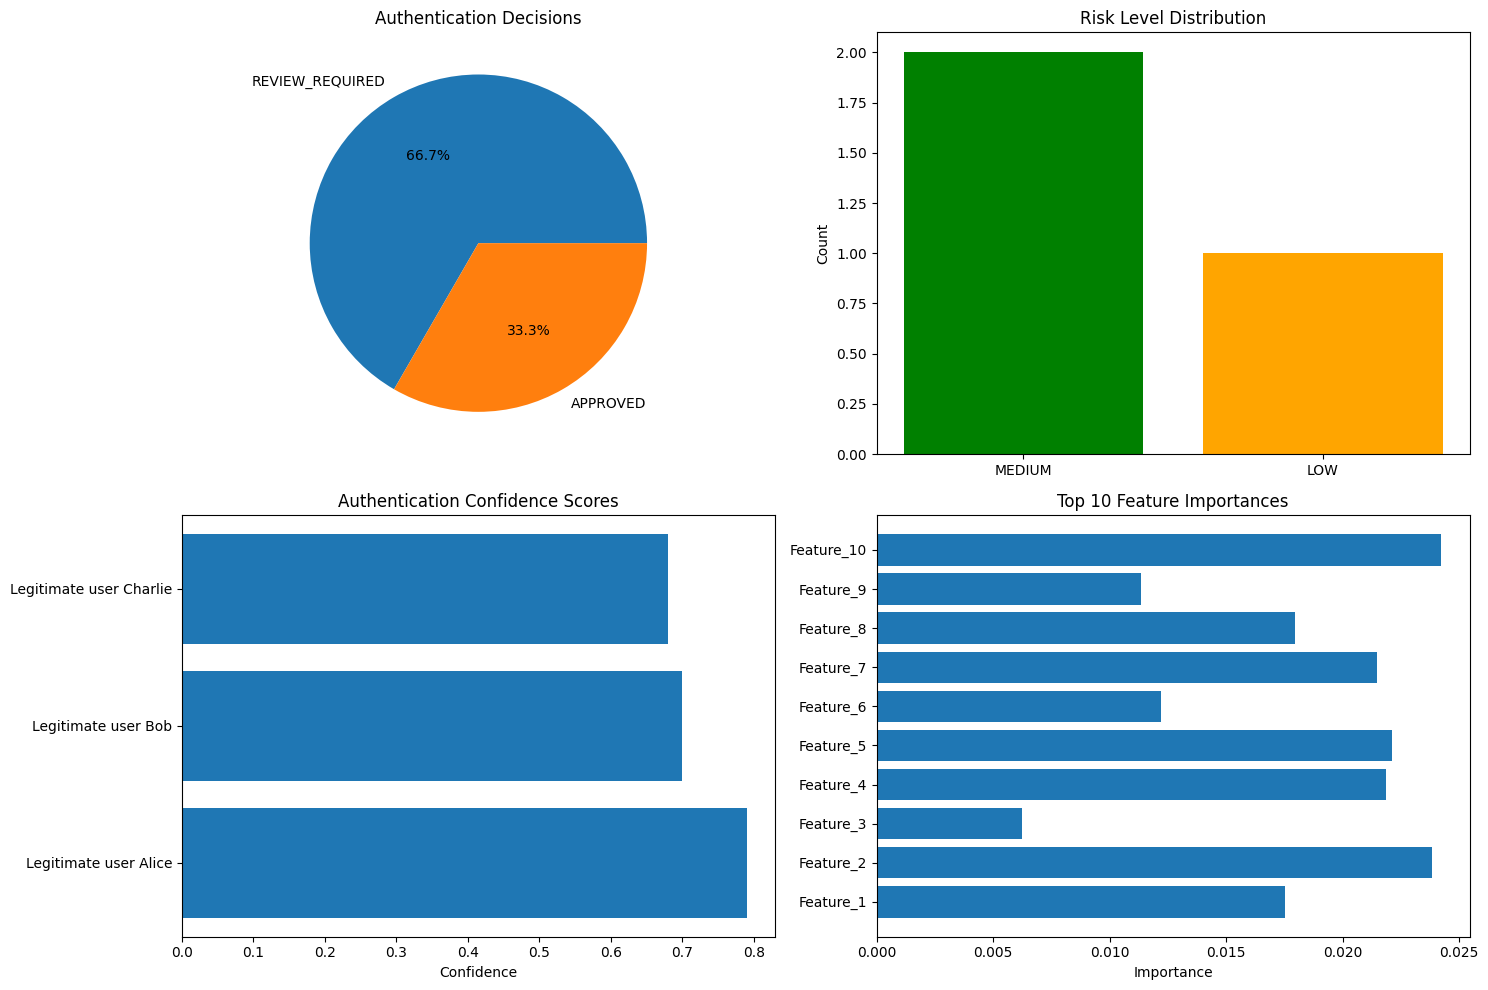


🔊 Audio Sample Visualization


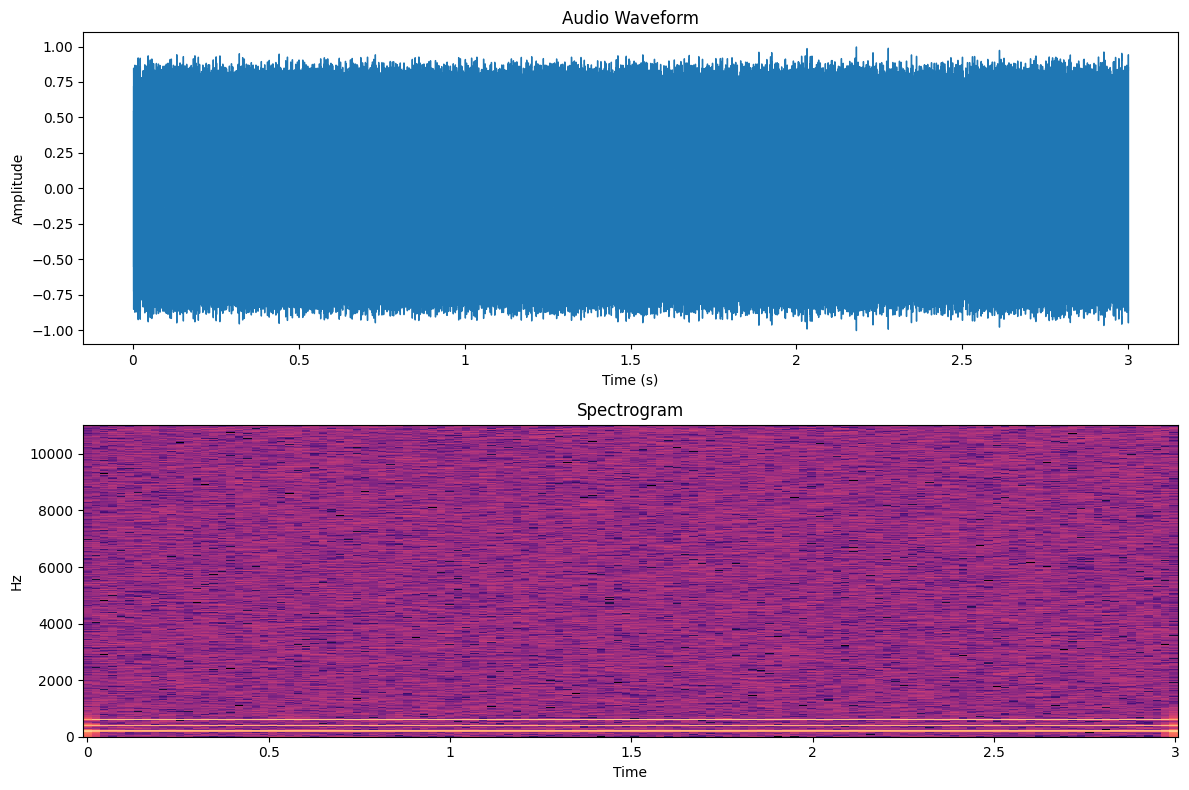

🚀 Interactive Voice Fraud Detection Demo
Generating sample audio files...
✓ Sample audio files generated successfully!
Registering user: alice
✓ Processed sample 1/2
✓ Processed sample 2/2
✓ User alice registered successfully with 2 samples
Registering user: bob
✓ Processed sample 1/2
✓ Processed sample 2/2
✓ User bob registered successfully with 2 samples
Registering user: charlie
✓ Processed sample 1/2
✓ Processed sample 2/2
✓ User charlie registered successfully with 2 samples
Training fraud detection model...
✓ Model trained successfully!
✓ Accuracy: 60.00%
✓ Training samples: 21 (6 genuine, 15 fraudulent)



✅ DEMO COMPLETE!
Your voice recognition anti-fraud system is ready!

📋 HACKATHON PRESENTATION POINTS:
• Real-time voice authentication
• ML-based fraud detection
• Risk scoring system
• Scalable architecture
• Privacy-preserving design


In [ ]:
main()